In [1]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "llama2", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT

'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}'

### Original Dataset

In [2]:
import pandas as pd
df = pd.read_csv("en-sp.csv")
df = df.sample(250, random_state=42)
# df to dict without indices
df_dict = df.to_dict(orient='records')
# dict with two keys: english and spanish
original_data = {"english": [], "spanish": []}
for row in df_dict:
    original_data["english"].append(row["english"])
    original_data["spanish"].append(row["spanish"])
original_data = Dataset.from_dict(original_data)
original_data["english"][:5], original_data["spanish"][:5]

(['How boring!',
  'I love sports.',
  'Would you like to swap jobs?',
  'My mother did nothing but weep.',
  'Croatia is in the southeastern part of Europe.'],
 ['¡Qué aburrimiento!',
  'Adoro el deporte.',
  '¿Te gustaría que intercambiemos los trabajos?',
  'Mi madre no hizo nada sino llorar.',
  'Croacia está en el sudeste de Europa.'])

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "english": \"\"\"{question}\"\"\",
    "spanish": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step. Respond with only the JSON object!
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["english"][0],
            answer=original_data["spanish"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )

    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_translations_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'question': "Don't be mad at me", 'answer': 'No te enfades conmigo'},
 {'question': 'I hate the weather here!', 'answer': '¡Odio el clima aquí!'},
 {'question': 'I saw a dog today.', 'answer': 'Vi un perro hoy.'},
 {'question': '"¿Qué es esto?"', 'answer': '"¿Qué es esto?"'},
 {'question': 'Open your eyes. ', 'answer': 'Abre los ojos. '},
 {'question': 'Come on!', 'answer': '¡Vamos!'},
 {'question': 'Let me do it.', 'answer': 'Déjame hacerlo.'},
 {'question': 'This is fine.', 'answer': 'Está bien.'},
 {'question': 'Your chances are zero', 'answer': 'Tus posibilidades son cero'},
 {'question': 'Stinking up the place!', 'answer': '¡ Apesta a todo dar!'},
 {'question': 'Thank you', 'answer': 'Gracias'},
 {'question': 'How high?', 'answer': '¿Qué tan alto?'},
 {'question': '¡Qué divertido!', 'answer': 'How exciting!'},
 {'question': 'Are you going to buy that?', 'answer': '¿Vas a comprar eso?'},
 {'question': 'Vamos a por ello!', 'answer': "Let's go!"},
 {'question': 'Is this food okay?'

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "english": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "spanish": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "english": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "spanish": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["english"]), len(training_sample["spanish"]), len(testing_sample["english"]), len(testing_sample["spanish"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [5]:
def has_correct_keywords(s):
    extract_keys = lambda x: re.findall(r'{(.*?)}', x)
    return extract_keys(s) == ['LANGUAGE', 'TEXT']


def opt_llm(instruction_score_pairs):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = opro.generate(
            prompt.format(pairs_str=pairs_str),
            model="gemini",  # gemini
            is_indeterministic=True,
        )
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(LANGUAGE="Spanish", TEXT=sample_qa["english"]),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += opro.similarity(sample_qa["spanish"], res)
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [14]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_translations_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        CHOSEN_PROMPT,
        f"{CHOSEN_PROMPT}. Think step by step.",
        f"{CHOSEN_PROMPT}. Take a deep breath and think step-by-step.",
        f"{CHOSEN_PROMPT}. Be concise and clear.",
        f"{CHOSEN_PROMPT}. You are the creator of an atlas.",
        f"{CHOSEN_PROMPT}. Explain your answer in simple terms.",
        # Prompt1 from Suggest Prompt
        """### Prompt
        
I'm going to tip $10 for a better solution!
```
### Instructions

### Example
Translate \"Hello, world!\" to French.
```

Your task is to help me to translate the following text to {LANGUAGE}. Please return only translated content, do not include the original text. 

{TEXT}

You MUST format the translated text in the following way: 

```
{{TRANSLATED TEXT}}
```

You will be penalized if you do not follow this format.

Answer a question given in a natural, human-like manner

---

Would you like me to add anything else? (yes/no)""",
        # Prompt2 from Suggest Prompt
        """Translate the following text to *{LANGUAGE}*.
Return only the translated content. Do not include the original text.

**Text**: {TEXT}

### Notes ###
- No need for polite language.
- Ensure your response is in *{LANGUAGE}*. 
- I'm offering a tip for a higher quality translation.""",
        # Prompt3 from Suggest Prompt
        """###Instruction###

Please help me to translate the following text to {LANGUAGE}. Please return only translated text, not including the origin text.

###Example###

####
{TEXT}
####

###Question###

What is the translated text?""",
        # Prompt4 from Suggest Prompt
        """####
Your task is to translate the following text to {LANGUAGE}. You MUST only return the translated content and exclude the original text.

{TEXT}

### Instruction###
I'm going to tip $100 for a better solution! I need the translation to be of high quality and accurate.""",
        # Prompt5 from Suggest Prompt
        """###Instruction###
Translate the following text into {LANGUAGE}:

###Example###
**English to Spanish:**
```
Original text: Hello, world!
Translated text: ¡Hola, mundo!
```

###Question###
I'm providing you with the original text below: {TEXT}. Translate it to {LANGUAGE} and return only the translated content without including the original text.""",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Step 11


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}:\n\n{TEXT}\n\n**Notes**:\n- Only provide the translated content, excluding the original text.\n- Aim for quality, not quantity.\n- Avoid direct translations and ensure the result reads smoothly.\n- Remove any unnecessary salutations or additional information.', 'Translate the following text to {LANGUAGE}:\n\n{TEXT}\n\nNotes:\n- No chitchat.\n- Be precise.\n- Return only the translated content, do not include the original text.', 'Translate the below text into {LANGUAGE}. Remove unnecessary prefixes, suffixes, or acknowledgements. Additionally, do not include the original text.\n\n{TEXT}', 'Translate the following text into {LANGUAGE}. Please provide only the translation, omitting the original. Ensure a high-quality translation free of grammatical errors and awkward phrasing. Conciseness and clarity are crucial.\n\n{TEXT}\n\n**Note**: No additional context or annotations should be included.', "Translate the provided text to {LANGUAGE}:\n\n{

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}:

{TEXT}

**Notes**:
- Only provide the translated content, exclu…

Translate the following text to {LANGUAGE}:

{TEXT}

Notes:
- No chitchat.
- Be precise.
- Return only the tra…

Translate the below text into {LANGUAGE}. Remove unnecessary prefixes, suffixes, or acknowledgements. Addition…

Translate the following text into {LANGUAGE}. Please provide only the translation, omitting the original. Ensu…

Translate the provided text to {LANGUAGE}:

{TEXT}

**Notes:**

- Only include the translated text and exclude…

Translate the following text to {LANGUAGE}:

{TEXT}

**Note**: Provide a high-quality translation only, omitti…

Translate the following text into {LANGUAGE}, providing only the translated text without including any other c…

Translate the following text to {LANGUAGE}, providing only the translated text and excluding the original. Ens…

{'Translate the following text into {LANGUAGE}:\n\n{TEXT}\n\n**Notes**:\n- Only provide the translated content, excluding the original text.\n- Aim for quality, not quantity.\n- Avoid direct translations and ensure the result reads smoothly.\n- Remove any unnecessary salutations or additional information.': 53.6855673789978, 'Translate the following text to {LANGUAGE}:\n\n{TEXT}\n\nNotes:\n- No chitchat.\n- Be precise.\n- Return only the translated content, do not include the original text.': 54.78341311216355, 'Translate the below text into {LANGUAGE}. Remove unnecessary prefixes, suffixes, or acknowledgements. Additionally, do not include the original text.\n\n{TEXT}': 65.92122614383698, 'Translate the following text into {LANGUAGE}. Please provide only the translation, omitting the original. Ensure a high-quality translation free of grammatical errors and awkward phrasing. Conciseness and clarity are crucial.\n\n{TEXT}\n\n**Note**: No additional context or annotations should be incl

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}. Provide a concise, accurate translation, excluding the original text.\n\n{TEXT}', 'Translate the following text into {LANGUAGE}. Please provide only the translated text, omitting all other information.\n\n{TEXT}', 'Translate the following text to {LANGUAGE}, excluding any context, prefixes, suffixes, or additional information. Please provide only the translated text:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}:\n\n{TEXT}\n\n**Note**:\n- Translate the text without including the original text.\n- Ensure the translation is clear, concise, accurate, and follows the grammar and syntax of the target language.\n- Omit any unnecessary prefixes, suffixes, or acknowledgements.\n- Avoid using awkward phrasing or direct translations.', 'Translate the below text into {LANGUAGE}. Return only translated content with no original text.\n\n{TEXT}', 'Translate the following text to {LANGUAGE}. Return only the translated content, excluding the 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}. Provide a concise, accurate translation, excluding the original …

Translate the following text into {LANGUAGE}. Please provide only the translated text, omitting all other info…

Translate the following text to {LANGUAGE}, excluding any context, prefixes, suffixes, or additional informati…

Translate the following text into {LANGUAGE}:

{TEXT}

**Note**:
- Translate the text without including the or…

Translate the below text into {LANGUAGE}. Return only translated content with no original text.

{TEXT}:   0%|…

Translate the following text to {LANGUAGE}. Return only the translated content, excluding the original text:

…

Translate the following text into {LANGUAGE}.
{TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}:

{TEXT}

**Note:** Return only the translated text.:   0%|      …

{'Translate the following text into {LANGUAGE}. Provide a concise, accurate translation, excluding the original text.\n\n{TEXT}': 59.00106847286224, 'Translate the following text into {LANGUAGE}. Please provide only the translated text, omitting all other information.\n\n{TEXT}': 56.537269204854965, 'Translate the following text to {LANGUAGE}, excluding any context, prefixes, suffixes, or additional information. Please provide only the translated text:\n\n{TEXT}': 72.91596829891205, 'Translate the following text into {LANGUAGE}:\n\n{TEXT}\n\n**Note**:\n- Translate the text without including the original text.\n- Ensure the translation is clear, concise, accurate, and follows the grammar and syntax of the target language.\n- Omit any unnecessary prefixes, suffixes, or acknowledgements.\n- Avoid using awkward phrasing or direct translations.': 62.154819667339325, 'Translate the below text into {LANGUAGE}. Return only translated content with no original text.\n\n{TEXT}': 54.29956465959549

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text to {LANGUAGE} in a concise, clear, and precise way. Only provide the translated content.\n\n{TEXT}', 'Translate the following text into {LANGUAGE}. Please provide a concise translation and include only the translated text:\n\n{TEXT}\n*Note*: Be succinct and precise in your translation. Exclude any unnecessary details or annotations. Ensure the translated text is grammatically correct and has a natural flow.', 'Translate the following text to {LANGUAGE}. Do not include the original text, any comments, prefixes, or suffixes. Provide only the high-quality translation.\n\n{TEXT}', 'Translate the below text into {LANGUAGE} without including the original text:\n\n{TEXT}', 'Translate the following text to {LANGUAGE}:\n\n{TEXT}', 'Translate the following text into the target {LANGUAGE}, excluding any additional information, context, examples, or attachments. Return only the translated text, ensuring clarity and accuracy.\n\n{TEXT}', 'Translate the following text 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE} in a concise, clear, and precise way. Only provide the translated c…

Translate the following text into {LANGUAGE}. Please provide a concise translation and include only the transl…

Translate the following text to {LANGUAGE}. Do not include the original text, any comments, prefixes, or suffi…

Translate the below text into {LANGUAGE} without including the original text:

{TEXT}:   0%|          | 0/10 […

Translate the following text to {LANGUAGE}:

{TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Translate the following text into the target {LANGUAGE}, excluding any additional information, context, exampl…

Translate the following text into {LANGUAGE}, excluding any irrelevant information or notes. Only provide the …

Translate the provided text to {LANGUAGE}, including only the translated content and no additional information…

{'Translate the following text to {LANGUAGE} in a concise, clear, and precise way. Only provide the translated content.\n\n{TEXT}': 54.75095331668853, 'Translate the following text into {LANGUAGE}. Please provide a concise translation and include only the translated text:\n\n{TEXT}\n*Note*: Be succinct and precise in your translation. Exclude any unnecessary details or annotations. Ensure the translated text is grammatically correct and has a natural flow.': 64.23439264297485, 'Translate the following text to {LANGUAGE}. Do not include the original text, any comments, prefixes, or suffixes. Provide only the high-quality translation.\n\n{TEXT}': 68.00314754247665, 'Translate the below text into {LANGUAGE} without including the original text:\n\n{TEXT}': 60.297469794750214, 'Translate the following text to {LANGUAGE}:\n\n{TEXT}': 47.081865072250366, 'Translate the following text into the target {LANGUAGE}, excluding any additional information, context, examples, or attachments. Return on

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}. Include only the relevant translation, omitting the original text and any unnecessary context or additional information. Ensure the translation is concise, accurate, and reflects the style and tone of the target language:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}, ensuring the translation is precise and free of any unnecessary context or instructions. Provide only the translated text in a clear and direct manner.\n\n{TEXT}', 'Translate the following text to {LANGUAGE}, providing only the translated text. Ensure the translation is concise, grammatically correct, and closely adheres to the original meaning. Please exclude any additional context or explanations.\n\n{TEXT}', 'Translate the provided text into {LANGUAGE}. Return only the translation, excluding any formatting, notes, or additional information:\n\n{TEXT}', 'Translate the provided text into the desired {LANGUAGE}, excluding any annotations, additional context or ex

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}. Include only the relevant translation, omitting the original tex…

Translate the following text into {LANGUAGE}, ensuring the translation is precise and free of any unnecessary …

Translate the following text to {LANGUAGE}, providing only the translated text. Ensure the translation is conc…

Translate the provided text into {LANGUAGE}. Return only the translation, excluding any formatting, notes, or …

Translate the provided text into the desired {LANGUAGE}, excluding any annotations, additional context or expl…

Translate the following text into {LANGUAGE}. Ensure the translation is accurate and of high quality. Return o…

Translate the included text into {LANGUAGE}, but include solely the translated text. Exclude any quotations, s…

Translate the following text into {LANGUAGE}, excluding any redundant or unnecessary content. Provide only a h…

{'Translate the following text into {LANGUAGE}. Include only the relevant translation, omitting the original text and any unnecessary context or additional information. Ensure the translation is concise, accurate, and reflects the style and tone of the target language:\n\n{TEXT}': 65.99154949188232, 'Translate the following text into {LANGUAGE}, ensuring the translation is precise and free of any unnecessary context or instructions. Provide only the translated text in a clear and direct manner.\n\n{TEXT}': 58.36169317364692, 'Translate the following text to {LANGUAGE}, providing only the translated text. Ensure the translation is concise, grammatically correct, and closely adheres to the original meaning. Please exclude any additional context or explanations.\n\n{TEXT}': 69.59936916828156, 'Translate the provided text into {LANGUAGE}. Return only the translation, excluding any formatting, notes, or additional information:\n\n{TEXT}': 71.4281216263771, 'Translate the provided text into 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the provided text into {LANGUAGE}: \n\n{TEXT}\n\n**NB:** Include the following in the translation:\n- Avoid using technical terms or jargon.\n- Ensure the translation is accurate, complete, and grammatically correct.\n- Convey the original meaning and tone of the text.\n- Only provide the translated text without additional comments or context.', 'Translate the following text to {LANGUAGE} without including anything other than the translated text:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}. Return solely the translated text, excluding any source text, quotations, salutations, date/time stamps, and unnecessary phrasing or context. Ensure the translation is precise, grammatically correct, and tonally appropriate for the target language:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}, excluding any supporting content, explanations, and additional formatting. Please provide only the translation itself, ensuring accuracy and clarity.\n\n{TEXT}', 'Transla

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the provided text into {LANGUAGE}: 

{TEXT}

**NB:** Include the following in the translation:
- Avo…

Translate the following text to {LANGUAGE} without including anything other than the translated text:

{TEXT}:…

Translate the following text into {LANGUAGE}. Return solely the translated text, excluding any source text, qu…

Translate the following text into {LANGUAGE}, excluding any supporting content, explanations, and additional f…

Translate the text given below into {LANGUAGE}. Ensure that your translation is accurate, correct, and contain…

Translate the following text into {LANGUAGE}, ensuring accuracy and maintaining the intended meaning. Provide …

Translate the following text into {LANGUAGE} while adhering to the following guidelines:
- Exclude any additio…

Translate the following text into {LANGUAGE}, keeping the translation concise and straightforward. Avoid addin…

{'Translate the provided text into {LANGUAGE}: \n\n{TEXT}\n\n**NB:** Include the following in the translation:\n- Avoid using technical terms or jargon.\n- Ensure the translation is accurate, complete, and grammatically correct.\n- Convey the original meaning and tone of the text.\n- Only provide the translated text without additional comments or context.': 47.54816949367523, 'Translate the following text to {LANGUAGE} without including anything other than the translated text:\n\n{TEXT}': 62.23509967327118, 'Translate the following text into {LANGUAGE}. Return solely the translated text, excluding any source text, quotations, salutations, date/time stamps, and unnecessary phrasing or context. Ensure the translation is precise, grammatically correct, and tonally appropriate for the target language:\n\n{TEXT}': 64.30480822920799, 'Translate the following text into {LANGUAGE}, excluding any supporting content, explanations, and additional formatting. Please provide only the translation it

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the provided text into {LANGUAGE}, excluding any preambles or unnecessary details. Please ensure the translation is accurate and reflects the tone and style of the target language:\n\n{TEXT}.', "Translate the following text into {LANGUAGE}, providing solely the translated content. Exclude any supplementary information, context, preambles, or closing remarks. Ensure that the translation adheres to the target language's syntax and grammatical conventions. Do not include the original text.\n\n{TEXT}", 'Translate the provided text solely into {LANGUAGE}. Exclude any identifying information, unnecessary phrases, additional information, or notes. Focus on providing an accurate and clear translation that adheres to the correct grammar and style of the target language. The translated text should stand alone without any additional context or explanations. Please only include the translated text:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}, excluding all unnecessary con

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the provided text into {LANGUAGE}, excluding any preambles or unnecessary details. Please ensure the…

Translate the following text into {LANGUAGE}, providing solely the translated content. Exclude any supplementa…

Translate the provided text solely into {LANGUAGE}. Exclude any identifying information, unnecessary phrases, …

Translate the following text into {LANGUAGE}, excluding all unnecessary context, explanations, additional form…

Translate the following text into the target {LANGUAGE}:

{TEXT}

**Note:**
- Ensure the translation is accura…

Translate the provided text into {LANGUAGE}. Please only include the translated text, excluding any introducto…

Translate the provided text into {LANGUAGE}, ensuring that the translation is precise and comprehensive. Provi…

Translate the following text to {LANGUAGE}. Do not include the original text or any additional information. Pr…

{'Translate the provided text into {LANGUAGE}, excluding any preambles or unnecessary details. Please ensure the translation is accurate and reflects the tone and style of the target language:\n\n{TEXT}.': 65.09219348430634, "Translate the following text into {LANGUAGE}, providing solely the translated content. Exclude any supplementary information, context, preambles, or closing remarks. Ensure that the translation adheres to the target language's syntax and grammatical conventions. Do not include the original text.\n\n{TEXT}": 72.10087329149246, 'Translate the provided text solely into {LANGUAGE}. Exclude any identifying information, unnecessary phrases, additional information, or notes. Focus on providing an accurate and clear translation that adheres to the correct grammar and style of the target language. The translated text should stand alone without any additional context or explanations. Please only include the translated text:\n\n{TEXT}': 73.77638757228851, 'Translate the foll

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}, providing only the translated text, excluding all surrounding remarks. Please ensure the translation captures the intended meaning effectively.\n\n{TEXT}', 'Translate the provided text to {LANGUAGE}, excluding any unnecessary phrases, additional information or explanations, or formatting. Provide only the translated text, ensuring accuracy and adherence to proper grammar and style. The output should be a standalone translation without any additional context:\n\n{TEXT}', 'Translate the provided text into {LANGUAGE}, ensuring it is a precise and complete translation that reflects the original meaning. Omit any surrounding text, notes, examples, or additional information. Only include the translated text:\n\n{TEXT}', 'Translate the provided text into {LANGUAGE}, excluding any external references, metadata, or additional context. The translated text should stand alone as a clear and concise rendering of the original text, adhering to the gram

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}, providing only the translated text, excluding all surrounding re…

Translate the provided text to {LANGUAGE}, excluding any unnecessary phrases, additional information or explan…

Translate the provided text into {LANGUAGE}, ensuring it is a precise and complete translation that reflects t…

Translate the provided text into {LANGUAGE}, excluding any external references, metadata, or additional contex…

Provide only the translation of the following text into {LANGUAGE}:

{TEXT}:   0%|          | 0/10 [00:00<?, ?…

Translate the following text into {LANGUAGE}, ensuring accuracy and clarity. Include only the translation, exc…

Translate the following text exclusively into {LANGUAGE}:

{TEXT}

**Instructions**:
- Limit your response to …

Translate the provided text into {LANGUAGE}, excluding any unnecessary context, additional formatting, notes, …

{'Translate the following text into {LANGUAGE}, providing only the translated text, excluding all surrounding remarks. Please ensure the translation captures the intended meaning effectively.\n\n{TEXT}': 57.22845748066903, 'Translate the provided text to {LANGUAGE}, excluding any unnecessary phrases, additional information or explanations, or formatting. Provide only the translated text, ensuring accuracy and adherence to proper grammar and style. The output should be a standalone translation without any additional context:\n\n{TEXT}': 70.8928906917572, 'Translate the provided text into {LANGUAGE}, ensuring it is a precise and complete translation that reflects the original meaning. Omit any surrounding text, notes, examples, or additional information. Only include the translated text:\n\n{TEXT}': 76.5584796667099, 'Translate the provided text into {LANGUAGE}, excluding any external references, metadata, or additional context. The translated text should stand alone as a clear and conci

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Translate the following text into {LANGUAGE}, ensuring only the translated text is included. Exclude any additional formatting, supplementary information, or notes. Please adhere to the target language's grammatical and stylistic conventions, ensuring clarity and accuracy. The translated text should stand alone without any additional context.\n\n{TEXT}", "Translate the following text into {LANGUAGE}, excluding any prefixes, suffixes, unnecessary phrases, contextual information, or additional formatting. Provide a standalone translation that adheres to the target language's grammar and style conventions, ensuring clarity and accuracy.\n\n{TEXT}", 'Translate the provided text into {LANGUAGE}, ensuring it is a precise and understandable translation that retains the original meaning. Omit any accompanying information, explanations, and additional notes. Return only the translated text:\n\n{TEXT}', "Translate the provided text to {LANGUAGE}. Exclude any unnecessary content, including cont

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}, ensuring only the translated text is included. Exclude any addit…

Translate the following text into {LANGUAGE}, excluding any prefixes, suffixes, unnecessary phrases, contextua…

Translate the provided text into {LANGUAGE}, ensuring it is a precise and understandable translation that reta…

Translate the provided text to {LANGUAGE}. Exclude any unnecessary content, including context, examples, suppl…

Translate the following text into {LANGUAGE}:

{TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE} with high quality, clarity, conciseness, and grammatical correctnes…

Provide a high-quality translation of the following text to {LANGUAGE}:

{TEXT}:   0%|          | 0/10 [00:00<…

Translate the following content to {LANGUAGE}, incorporating only the relevant translated text. Exclude any id…

{"Translate the following text into {LANGUAGE}, ensuring only the translated text is included. Exclude any additional formatting, supplementary information, or notes. Please adhere to the target language's grammatical and stylistic conventions, ensuring clarity and accuracy. The translated text should stand alone without any additional context.\n\n{TEXT}": 68.13249319791794, "Translate the following text into {LANGUAGE}, excluding any prefixes, suffixes, unnecessary phrases, contextual information, or additional formatting. Provide a standalone translation that adheres to the target language's grammar and style conventions, ensuring clarity and accuracy.\n\n{TEXT}": 61.446601152420044, 'Translate the provided text into {LANGUAGE}, ensuring it is a precise and understandable translation that retains the original meaning. Omit any accompanying information, explanations, and additional notes. Return only the translated text:\n\n{TEXT}': 70.72154432535172, "Translate the provided text to {

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Translate the provided text into {LANGUAGE}, maintaining the original's accuracy, clarity, and meaning. Exclude any unnecessary information, such as annotations, formatting, disclaimers, or examples. The translated text should stand alone as a precise and comprehensive representation of the original content:\n\n{TEXT}", 'Translate the following text into {LANGUAGE} with utmost precision, clarity, and completeness. Ensure that the translation accurately reflects the meaning, tone, and context of the original text. Exclude any unnecessary additions, notes, or supplementary information. The translated text should be a standalone piece, intelligible to speakers of the target language without any external references or context.\n\n{TEXT}', "Translate the following text to {LANGUAGE} while maintaining a high degree of accuracy, completeness, and clarity. Please only include the translated text, excluding any additional information such as notes, examples, context, or references. Ensure tha

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the provided text into {LANGUAGE}, maintaining the original's accuracy, clarity, and meaning. Exclud…

Translate the following text into {LANGUAGE} with utmost precision, clarity, and completeness. Ensure that the…

Translate the following text to {LANGUAGE} while maintaining a high degree of accuracy, completeness, and clar…

Translate the provided text accurately and comprehensively into {LANGUAGE}. Ensure that the translation reads …

Translate the following text into {LANGUAGE}, prioritizing clarity, accuracy, and adherence to grammar rules. …

Translate the following text into {LANGUAGE}, excluding any unnecessary context, explanations, examples, addit…

Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains t…

Translate the provided text into {LANGUAGE}. We need only the translated text, not the original text or any ad…

{"Translate the provided text into {LANGUAGE}, maintaining the original's accuracy, clarity, and meaning. Exclude any unnecessary information, such as annotations, formatting, disclaimers, or examples. The translated text should stand alone as a precise and comprehensive representation of the original content:\n\n{TEXT}": 70.08370220661163, 'Translate the following text into {LANGUAGE} with utmost precision, clarity, and completeness. Ensure that the translation accurately reflects the meaning, tone, and context of the original text. Exclude any unnecessary additions, notes, or supplementary information. The translated text should be a standalone piece, intelligible to speakers of the target language without any external references or context.\n\n{TEXT}': 59.938784688711166, "Translate the following text to {LANGUAGE} while maintaining a high degree of accuracy, completeness, and clarity. Please only include the translated text, excluding any additional information such as notes, examp

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text to {LANGUAGE} while retaining its original intent and ensuring it is linguistically correct. Include only the translated text without any additional information or context:\n\n{TEXT}', "Translate the provided text to {LANGUAGE}, providing only the translated text. Exclude any additional information not strictly necessary for understanding, such as examples, explanations, disclaimers, and context. Ensure accuracy and adherence to the target language's grammatical conventions:\n\n{TEXT}", 'Translate the provided text into {LANGUAGE}, excluding any extra content, notes, or examples. Provide only the translated text, ensuring accuracy and attention to language-specific nuances to maintain the intended meaning. The output should be a standalone translation, without any additional context or references:\n{TEXT}', 'Translate the following text into {LANGUAGE}, ensuring it is an accurate and complete translation that retains the original meaning. Omit any additio

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE} while retaining its original intent and ensuring it is linguistical…

Translate the provided text to {LANGUAGE}, providing only the translated text. Exclude any additional informat…

Translate the provided text into {LANGUAGE}, excluding any extra content, notes, or examples. Provide only the…

Translate the following text into {LANGUAGE}, ensuring it is an accurate and complete translation that retains…

Translate the following text into {LANGUAGE}. Please exclude references to the original text, additional infor…

Translate the following text into {LANGUAGE}, providing a precise and exhaustive translation that retains the …

Translate the following text into {LANGUAGE}, ensuring it is an accurate and faithful translation that retains…

Translate the provided text into {LANGUAGE}. Only include the translated text, avoiding any surrounding text, …

{'Translate the following text to {LANGUAGE} while retaining its original intent and ensuring it is linguistically correct. Include only the translated text without any additional information or context:\n\n{TEXT}': 68.94992709159851, "Translate the provided text to {LANGUAGE}, providing only the translated text. Exclude any additional information not strictly necessary for understanding, such as examples, explanations, disclaimers, and context. Ensure accuracy and adherence to the target language's grammatical conventions:\n\n{TEXT}": 70.86088687181473, 'Translate the provided text into {LANGUAGE}, excluding any extra content, notes, or examples. Provide only the translated text, ensuring accuracy and attention to language-specific nuances to maintain the intended meaning. The output should be a standalone translation, without any additional context or references:\n{TEXT}': 71.91265732049942, 'Translate the following text into {LANGUAGE}, ensuring it is an accurate and complete transl

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

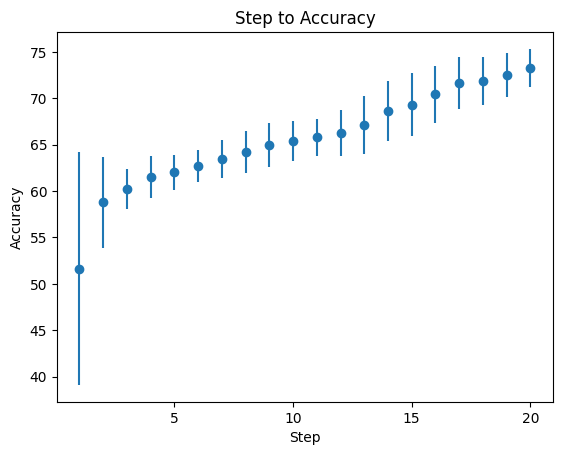

In [15]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [16]:
opro_results[str(len(opro_results))]

{'Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains the original meaning. Include only the translation, excluding any additional information, notes, or examples. Only include the translated text:\n\n{TEXT}': 76.57797873020172,
 'Translate the provided text into {LANGUAGE}, ensuring it is a precise and complete translation that reflects the original meaning. Omit any surrounding text, notes, examples, or additional information. Only include the translated text:\n\n{TEXT}': 76.5584796667099,
 'Translate the following text into {LANGUAGE}, excluding any supporting content, explanations, and additional formatting. Please provide only the translation itself, ensuring accuracy and clarity.\n\n{TEXT}': 76.22225493192673,
 'Translate the following text into the target {LANGUAGE}, excluding any additional information, context, examples, or attachments. Return only the translated text, ensuring clarity and accuracy.\n\n{TEXT}': 76.180502

In [17]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Initial Prompt: 55.97335430979729


Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains t…

Optimized Prompt (Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains the original meaning. Include only the translation, excluding any additional information, notes, or examples. Only include the translated text:

{TEXT}): 60.92241567373276


In [18]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, original_data)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, original_data)}")

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Initial Prompt: 69.62939703315496


Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains t…

Optimized Prompt (Translate the following text into {LANGUAGE}, ensuring it is a precise and complete translation that retains the original meaning. Include only the translation, excluding any additional information, notes, or examples. Only include the translated text:

{TEXT}): 73.90900953449308


### Example

In [19]:
res = opro.generate(
    best_instruction.format(LANGUAGE="Spanish", TEXT=original_data["english"][0]),
    model="gemma",  # gemma
)
original_data["spanish"][0], res, opro.similarity(original_data["spanish"][0], res)

('¡Qué aburrimiento!', 'No es divertido.', 0.4487640857696533)

In [20]:
res = opro.generate(
    CHOSEN_PROMPT.format(LANGUAGE="Spanish", TEXT=original_data["english"][0]),
    model="gemma",  # gemma
)
original_data["spanish"][0], res, opro.similarity(original_data["spanish"][0], res)

('¡Qué aburrimiento!',
 '¡Es aburrido!\n\nThe translated text is "How boring!".',
 0.7065099477767944)